# Analytics For Unstructured Data: Group Assignment #1

### Group Members:

**Marcus Martinez, Marifer Martinez-Garcia, Kennedy Zapalac, Alexander Schmelzeis, Milan Vaghani, Kennedy Zapalac**

In [12]:
# # install if necessary
# !pip install selenium
# !apt-get -q update   #Used to handle installation and removal of softwares and libraries
# !apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [1]:
# import necessary libraries for everything
# System and path setup
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')  # Ensure Python can find ChromeDriver

# Web scraping libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

# Time utilities
import time

# Data manipulation and file handling
import pandas as pd
import numpy as np
import csv
import shutil
from tempfile import NamedTemporaryFile
import io

# Natural language processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from collections import Counter, defaultdict
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and text processing
from sklearn import manifold
from sklearn.feature_extraction.text import CountVectorizer

# Additional utilities
import itertools
from itertools import combinations
import decimal
import operator

/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Scraper
https://realpython.com/modern-web-automation-with-python-and-selenium/ 

In [14]:
# #WebDriver is a browser automation framework that works with open source APIs.
# #The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
# chrome_options = webdriver.ChromeOptions()
# #headless means running chrome with chrome.exe
# chrome_options.add_argument('--headless')

# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--disable-dev-shm-usage')

In [15]:
# driver = webdriver.Chrome(options=chrome_options)

# # Create DataFrame
# comments = pd.DataFrame(columns = ['Date','user_id','comments'])


# #Srape Dates, Usernames, and Comments from most recent 115 pages (about 5000 comments)
# for i in range(320,436):

#     #address where scraping
#     webpage = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(i)
#     driver.get(webpage)

#     ids = driver.find_elements(By.XPATH,"//*[contains(@id,'Comment_')]")

#     comment_ids = []

#     for i in ids:
#         comment_ids.append(i.get_attribute('id'))

#     #check if there is a blockquote (used in replies to comments) and remove
#     for x in comment_ids:
#         try:
#             element = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[3]/div/div[1]/blockquote')[0]
#             driver.execute_script("""
#                 var element = arguments[0];
#                 element.parentNode.removeChild(element);
#                 """, element)
#         except:
#             pass

#     for x in comment_ids:

#         #Extract dates from for each user on a page
#         user_date = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
#         date = user_date.get_attribute('title')

#         #Extract user ids from each user on a page
#         userid_element = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
#         userid = userid_element.text

#         #Extract Message for each user on a page
#         user_message = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]

#         comment = user_message.text


#         #Adding date, userid and comment for each user in a dataframe
#         comments.loc[len(comments)] = [date,userid,comment]

In [16]:
# #Nulls don't play well with the tokenizer, so drop nulls
# comments.dropna(inplace=True)

# #change the location as per the file destination you want it to be
# comments.to_csv('data/Edmunds_scraped2.0.csv', index=False)

In [2]:
# If working from CSV instead of scraping originally, read in CSV
comments = pd.read_csv('data/Edmunds_scraped2.0.csv')

## Task A: Zipf's Law

In [3]:
# raw word frequencies
# Download stopwords from the NLTK package
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Input and output filenames
input_filename = 'data/Edmunds_scraped2.0.csv'  # Input file
final_filename = 'data/final.csv'  # Intermediate file without the column header
word_freq_output = 'data/word_freq.csv'  # Output file for word frequencies

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    """
    Cleans a given sentence by removing punctuation, converting text to lowercase,
    and tokenizing the remaining words.
    """
    # Remove punctuation and convert text to lowercase
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())

    # Tokenize and remove stopwords
    return [word for word in sentence.split()]

# Step 1: Remove header from the input CSV and create a new file without it
def remove_header(input_file, output_file):
    """
    Reads the input CSV file, removes the header, and writes the remaining rows
    into a new output file.
    """
    file = pd.read_csv(input_file, header = None, skiprows = 1)
    file.to_csv(output_file, index = False)

# Step 2: Extract and clean sentences from the text
def extract_sentences(file):
    """
    Extracts text data from the third column of the CSV file, splits it into sentences,
    and cleans each sentence by removing punctuation and stopwords.
    """
    df = pd.read_csv(file, header = None)
    posts = df.iloc[:,2]
    sentences = []
    sentences_clean = []
    for post in posts:
        sentences.extend(re.split('[?.!]', post))
    for sentence in sentences:
        cleaned_tokens = clean_and_tokenize(sentence)
        if cleaned_tokens:
            sentences_clean.append(cleaned_tokens)
    return sentences_clean


# Step 3: Calculate word frequencies
def calculate_word_frequencies(sentences):
    """
    Calculates the frequency of each word in the given list of cleaned sentences.
    """
    freqs = {}
    total_words = 0
    for sentence in sentences:
        for word in sentence:
            freqs[word] = freqs.get(word, 0) + 1
            total_words += 1
    return freqs

# Step 4: Write word frequencies to CSV
def write_word_frequencies(word_freq, output_file):
    """
    Writes the word frequencies to the specified CSV file.
    """
    word_freq_df = pd.DataFrame(word_freq.items(), columns = ["Word", "Frequency"])
    word_freq_df = word_freq_df.sort_values(by = "Frequency", ascending = False)
    word_freq_df.to_csv(output_file, index=False)
    print(f"Word frequencies written to {output_file}")

# Main function to run all steps
def main():
    # Step 1: Remove header
    remove_header(input_filename, final_filename)
    
    # Step 2: Extract and clean sentences
    sentences = extract_sentences(final_filename)
    
    # Step 3: Calculate word frequencies
    word_freq = calculate_word_frequencies(sentences)
    
    # Step 4: Write word frequencies to CSV
    write_word_frequencies(word_freq, word_freq_output)

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fmunting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word frequencies written to data/word_freq.csv


Text(0.5, 1.0, 'Frequency vs. Rank for Top 100 Words in Edmunds Forum')

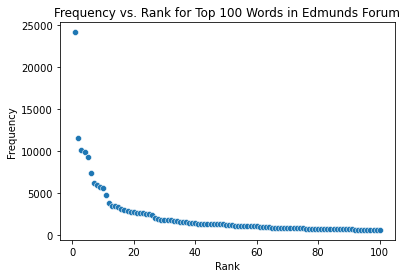

In [4]:
df = pd.read_csv('data/word_freq.csv')
df["rank"] = range(len(df))
df["rank"] += 1

X = df["rank"][:100]
y = df["Frequency"][:100]


sns.scatterplot(x = X, y = y)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Frequency vs. Rank for Top 100 Words in Edmunds Forum")

# this is the plot just for the top 100 frequencies as is, no log

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

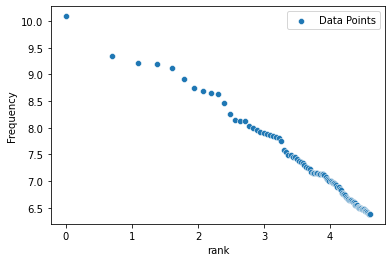

In [6]:
# actual data
x_log = np.log(X)
y_log = np.log(y)

# ideal data
y_ideal = len(df) * 1/X
y_log_ideal = np.log(y_ideal)


sns.scatterplot(x=x_log, y=y_log, label="Data Points")
sns.lineplot(x=x_log, y=y_log_ideal, color='green', label="Ideal Line")
plt.xlabel("Log Rank")
plt.ylabel("Log Frequency")
plt.title("Log Frequency vs. Rank for Top 100 Words in Edmunds Forum")

In [7]:
# test Zipf's law economometrically
df["theta"] = np.log(df["rank"]) / np.log(df["Frequency"] / len(df))
print("The average value of theta is: " + str(np.mean(df["theta"])))

The average value of theta is: -1.008228725373608


In [8]:
# Regression to test econometrically
y = np.log(df["rank"])
X = np.log(df["Frequency"] / len(df))

import statsmodels.api as sm
# Fit the model without an intercept
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   rank   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.074e+07
Date:                Thu, 19 Sep 2024   Prob (F-statistic):                        0.00
Time:                        19:17:07   Log-Likelihood:                         -10276.
No. Observations:               20843   AIC:                                  2.055e+04
Df Residuals:                   20842   BIC:                                  2.056e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
# Get coefficient for the variable of interest
coef = model.params.iloc[0]
std_err = model.bse.iloc[0]

# Hypothesized value (the value you want to test against)
hypothesized_value = -1

# Calculate t-statistic
t_stat = (coef - hypothesized_value) / std_err

# Calculate p-value from the t-statistic
from scipy import stats

# Degrees of freedom
df = model.df_resid

# Calculate two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=df))

print(f"Coefficient: {coef}")
print(f"Standard Error: {std_err}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("The coefficient is significantly different from -1.")
else:
    print("The coefficient is not significantly different from -1.")

Coefficient: -0.9930218397053712
Standard Error: 0.00030304796561198883
T-statistic: 23.026586832671253
P-value: 0.0
The coefficient is significantly different from -1.


**Zipf's law is not supported because $\theta$ is significantly different from -1 (p < .001).**

## Task B: Frequencies

### Find and Replace
Here we replace the car models with brands, and we've also include aspirational bigrams and trigrams to replace with "aspiration" for use later on.

In [21]:
# Filepaths
output_file = 'data/replacement_Edmunds.csv'  # The file where the modified data will be stored 
input_file = 'data/Edmunds_scraped2.0.csv'               # The file containing the original data
replacement_file = 'data/car_models_and_brands.csv'   # The file containing original and replacement words

# Create a temporary file to write the changes before moving it to the final location
tempfile = NamedTemporaryFile(mode='w', delete=False, newline='', encoding='utf-8')

def load_replacements(replacement_file):
    """
    Load word replacements from a CSV file into a dictionary.
    The right column contains words to be replaced by the corresponding words in the left column.
    """
    replacements = {}
    with open(replacement_file, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            original, replacement = row[1].lower(), row[0].lower()  # Ensure lowercase comparison
            replacements[original] = replacement
    return replacements

def replace_words_in_text(text, replacements):
    """
    Replace words or phrases (including bi-grams and tri-grams) in the input text according to the replacements dictionary.
    """
    # Sort replacements by length (so tri-grams are checked before bi-grams, etc.)
    sorted_replacements = sorted(replacements.keys(), key=lambda x: len(x.split()), reverse=True)
    
    # Create a pattern to match any n-grams (bi-grams, tri-grams, etc.)
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in sorted_replacements) + r')\b', re.IGNORECASE)
    
    # Function to preserve the original case of the replacement
    def replacement_func(match):
        original_word = match.group(0).lower()
        return replacements.get(original_word, original_word)
    
    # Replace matched phrases in the text using the generated pattern
    return pattern.sub(replacement_func, text)

def process_file(input_file, output_file, replacements):
    """
    Read the input file, perform word replacements, and write the modified content to the output file.
    """
    # Open input and temporary output files
    with open(input_file, 'r', encoding='utf-8') as infile, tempfile:
        reader = csv.reader(infile, delimiter=',', quotechar='"')
        writer = csv.writer(tempfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header if present
        header = next(reader)
        writer.writerow(header)
        
        for row in reader:
            new_row = [replace_words_in_text(cell, replacements) for cell in row]
            writer.writerow(new_row)

    # Replace the original file with the modified file
    shutil.move(tempfile.name, output_file)

def main():
    # Load the replacement words from the replacement CSV file
    replacements = load_replacements(replacement_file)

    # Process the input file and apply the replacements
    process_file(input_file, output_file, replacements)

if __name__ == "__main__":
    main()


**Use replacement_Edmunds.csv from now on!**

### Frequency Counts
We count the post word frequency now instead of total word frequency

In [22]:
# Download stopwords from the NLTK package
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Input and output filenames
input_filename = 'data/replacement_Edmunds.csv'  # Input file
word_freq_output = 'data/word_post_count.csv'  # Output file for word post count

# Function to clean text (removing punctuation and stopwords)
def clean_text(post):
    """
    Cleans a given post by removing punctuation and stopwords, and converting text to lowercase.
    """
    post = re.sub(f'[{re.escape(string.punctuation)}]', '', post.lower())  # Remove punctuation and convert to lowercase
    words = post.split()  # Tokenize the post
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Step 1: Clean the posts from the CSV
def clean_posts(input_file):
    """
    Reads the input CSV file, cleans the posts, and returns a list of cleaned posts.
    """
    df = pd.read_csv(input_file, header=None)  # Load CSV
    posts = df.iloc[:, 2]  # Extract the third column (posts)
    cleaned_posts = posts.apply(clean_text)  # Apply cleaning to each post
    return cleaned_posts

# Step 2: Use CountVectorizer to count how many posts each word appears in
def count_word_occurrences(posts):
    """
    Uses CountVectorizer to count how many posts each word appears in.
    """
    vectorizer = CountVectorizer(binary=True)  # binary=True to count post occurrences (not word frequency)
    X = vectorizer.fit_transform(posts)  # Transform the posts into a document-term matrix
    word_counts = X.toarray().sum(axis=0)  # Sum the binary values to get the number of posts each word appears in
    words = vectorizer.get_feature_names_out()  # Get the words from the vocabulary
    word_post_count = dict(zip(words, word_counts))  # Map words to their post counts
    return word_post_count

# Step 3: Write the word counts to a CSV file
def write_word_counts_to_csv(word_post_count, output_file):
    """
    Writes the word-post-counts to the specified CSV file.
    """
    word_post_count_df = pd.DataFrame(list(word_post_count.items()), columns=["Word", "Post_Count"])
    word_post_count_df = word_post_count_df.sort_values(by="Post_Count", ascending=False)
    word_post_count_df.to_csv(output_file, index=False)
    print(f"Word post counts written to {output_file}")

# Main function to run all steps
def main():
    # Step 1: Clean posts
    cleaned_posts = clean_posts(input_filename)
    
    # Step 2: Count how many posts each word appears in
    word_post_count = count_word_occurrences(cleaned_posts)
    
    # Step 3: Write word post counts to CSV
    write_word_counts_to_csv(word_post_count, word_freq_output)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fmunting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word post counts written to data/word_post_count.csv


In [23]:
freqs = pd.read_csv('data/word_post_count.csv')
freqs.head(10)

,Word,Post_Count
0,car,1881
1,like,1182
2,one,1066
3,would,1028
4,bmw,1020
5,get,905
6,think,860
7,new,830
8,audi,786
9,dont,747


The top 10 brands according to the post frequencies above are:
1. BMW
2. Audi
3. Acura
4. Honda
5. Volkswagen
6. Infiniti
7. Cadillac
8. Toyota
9. Lexus
10. Hyundai

## Task C: Lift Calculation

In [24]:
# Initialize global variables and data structures
df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])  # To store lift values
word_frequency = {}  # Dictionary to store word frequency in posts
word_pair_frequency = defaultdict(dict)  # Dictionary to store word pair co-occurrence frequency
results_dict = {}  # Dictionary to store results with lift values for word pairs
file_length = 0  # Number of rows in the input file
itr = 0  # Row iterator for the lift DataFrame

# File paths
input_file = 'data/replacement_Edmunds.csv'  # Input data file
pair_keys_file = 'edmunds_pair_keys.txt'  # File containing the words to calculate lift
output_lift_values = 'data/Lift_Values.csv'  # Output file for lift values
output_lift_matrix = 'data/Lift_Matrix.csv'  # Output file for lift matrix

# Load NLTK stopwords
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text (removes punctuation and stopwords)
def clean_text(text):
    """
    Cleans a given text by removing punctuation, converting it to lowercase,
    and tokenizing it, ignoring any stopwords.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    cleaned_tokens = [word for word in tokens if word not in stop_words]

    return cleaned_tokens

# Step 1: Load the words from the edmunds_pair_keys.txt file and generate all pairs
def load_word_pairs(filename):
    """
    Loads words from a file where words are comma-separated in each row.
    Returns a list of all possible word pairs for each row.
    """
    word_pairs = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Generate all possible word pairs from each row
            pairs = list(combinations(row, 2))
            word_pairs.extend(pairs)

    return word_pairs

# Step 2: Process the input CSV file to extract posts and clean the text
def process_input_file(input_filename):
    """
    Processes the input CSV file to extract and clean posts. Each post is tokenized,
    cleaned of punctuation and stopwords, and stored in a list.
    """
    posts = []
    global file_length
    df = pd.read_csv(input_filename)  # Load the CSV file into a DataFrame

    # Assuming 'comments' is the column that contains the text
    for index, row in df.iterrows():
        cleaned_post = clean_text(row['comments'])  # Clean and tokenize the post
        posts.append(cleaned_post)

    file_length = len(df)  # Get the total number of rows
    return posts

# Step 3: Calculate word frequencies and word pair co-occurrences (distance ≥ 7 words)
def calculate_frequencies(posts):
    """
    Calculates the frequency of individual words and word pairs within the posts.
    Updates the global word_frequency and word_pair_frequency dictionaries.
    Only considers word pairs that are 7 or more words apart.
    """
    global word_frequency, word_pair_frequency

    for post in posts:
        word_positions = {}  # Dictionary to track positions of each word

        # Track word positions
        for idx, word in enumerate(post):
            if word not in word_positions:
                word_positions[word] = []
            word_positions[word].append(idx)

        # Count word frequencies
        unique_words = set(post)  # Track unique words in the post to avoid double counting
        for word in unique_words:
            word_frequency[word] = word_frequency.get(word, 0) + 1

        # Track word pairs that have already been marked as co-occurring in this post
        seen_pairs = set()
        # Count word pair co-occurrences with distance check
        for word1 in word_positions:
            for word2 in word_positions:
                if word1 != word2 and (word1, word2) not in seen_pairs:
                    # Check if the words are 7 or fewer positions apart
                    found_pair = False
                    for pos1 in word_positions[word1]:
                        for pos2 in word_positions[word2]:
                            if abs(pos1 - pos2) <= 7:
                                word_pair_frequency[word1][word2] = word_pair_frequency.get(word1, {}).get(word2, 0) + 1
                                seen_pairs.add((word1, word2))  # Mark this pair as seen
                                found_pair = True
                                break  # No need to check more positions; move to the next pair
                        if found_pair:
                            break  # Stop after finding one valid pair in this post
                            
# Step 4: Calculate the lift between word pairs
def calculate_lift(word_pairs):
    """
    Calculates the lift between word pairs using the formula:
    Lift(word1, word2) = P(word1 AND word2) / (P(word1) * P(word2))
    Lift is written to the lift values CSV and stored in a DataFrame for further processing.
    """
    global itr
    
    for word1, word2 in word_pairs:
        # Get the frequency of word1, word2, and their co-occurrence
        freq_word1 = word_frequency.get(word1, 0)
        freq_word2 = word_frequency.get(word2, 0)
        co_occurrence = word_pair_frequency.get(word1, {}).get(word2, 0)

        # Calculate probabilities
        p_word1 = freq_word1 / file_length if freq_word1 else 0
        p_word2 = freq_word2 / file_length if freq_word2 else 0
        p_word1_and_word2 = co_occurrence / file_length if co_occurrence else 0

        # Avoid division by zero
        if p_word1 > 0 and p_word2 > 0:
            lift_value = p_word1_and_word2 / (p_word1 * p_word2) if (p_word1 * p_word2) > 0 else 0
        else:
            lift_value = 0
        # Store lift value in DataFrame
        df_lift.loc[itr] = [word1, word2, lift_value]
        itr += 1
    return df_lift

# Step 5: Write lift values and matrix to CSV
def save_results(df_lift):
    """
    Writes the calculated lift values to a CSV file and also generates a lift matrix,
    saving it to another CSV.
    """
    # Save lift values DataFrame to CSV
    # must create duplicate word pairs to create 10x10 matrix
    df_lift2 = pd.DataFrame({'word1':df_lift.word2, 'word2':df_lift.word1, 'lift_value':df_lift.lift_value})
    df_lift = pd.concat([df_lift, df_lift2], ignore_index=True)
    df_lift.to_csv(output_lift_values, index=False)

    # Generate lift matrix
    lift_matrix = pd.pivot_table(df_lift, values='lift_value', index='word1', columns='word2', fill_value=0)
    lift_matrix.index.name = ''
    lift_matrix.to_csv(output_lift_matrix)

# Main function to run all steps
def main():
    # Step 1: Load word pairs
    word_pairs = load_word_pairs(pair_keys_file)

    # Step 2: Process the input file to extract posts
    posts = process_input_file(input_file)

    # Step 3: Calculate frequencies
    calculate_frequencies(posts)

    # Step 4: Calculate lift values
    df_lift = calculate_lift(word_pairs)

    # Step 5: Save results
    save_results(df_lift)

# Run the script
if __name__ == "__main__":
    main()

In [25]:
# create lift matrices for brands, attributes, and aspiration
df_lift = pd.read_csv('data/Lift_Values.csv')

# brand lift matrix
# filter for car brand lifts
mask = (df_lift['word1'].str.contains('bmw|audi|acura|honda|volkswagen|infiniti|cadillac|toyota|lexus|hyundai') & 
        df_lift['word2'].str.contains('bmw|audi|acura|honda|volkswagen|infiniti|cadillac|toyota|lexus|hyundai'))
brand_lift = df_lift[mask]
brand_lift_matrix = pd.pivot_table(brand_lift, values='lift_value', index='word1', columns='word2', fill_value=0)
brand_lift_matrix.index.name = ''
brand_lift_matrix.columns.name = ''
brand_lift_matrix.to_csv('data/brand_lift_matrix.csv')
# remove upper triangular values for display
mask = np.triu(np.ones(brand_lift_matrix.shape, dtype=bool))
brand_lift_matrix = brand_lift_matrix.where(~mask)
brand_lift_matrix = brand_lift_matrix.fillna('')
display(brand_lift_matrix)

# attribute lift matrix
mask = (df_lift['word1'].str.contains('bmw|audi|acura|honda|volkswagen|infiniti|cadillac|toyota|lexus|hyundai') &
        df_lift['word2'].str.contains('price|sport|engine|performance|luxury'))
attr_lift = df_lift[mask]
attr_lift_matrix = pd.pivot_table(attr_lift, values='lift_value', index='word1', columns='word2', fill_value=0)
attr_lift_matrix.index.name = ''
attr_lift_matrix.columns.name = ''


# aspiration lift matrix
mask = (df_lift['word1'].str.contains('bmw|audi|acura|honda|volkswagen|infiniti|cadillac|toyota|lexus|hyundai') &
        df_lift['word2'].str.contains('aspiration'))
asp_lift = df_lift[mask]
asp_lift_matrix = pd.pivot_table(asp_lift, values='lift_value', index='word1', columns='word2', fill_value=0)
asp_lift_matrix.index.name = ''
asp_lift_matrix.columns.name = ''

# # unaspirational lift matrix
# mask = (df_lift['word1'].str.contains('bmw|audi|acura|honda|volkswagen|infiniti|cadillac|toyota|lexus|hyundai') &
#         df_lift['word2'].str.contains('unaspirational'))
# unasp_lift = df_lift[mask]
# unasp_lift_matrix = pd.pivot_table(unasp_lift, values='lift_value', index='word1', columns='word2', fill_value=0)
# unasp_lift_matrix.index.name = ''
# unasp_lift_matrix.columns.name = ''

,acura,audi,bmw,cadillac,honda,hyundai,infiniti,lexus,toyota,volkswagen
,,,,,,,,,,
acura,,,,,,,,,,
audi,1.026429,,,,,,,,,
bmw,0.566362,1.272265,,,,,,,,
cadillac,1.238826,1.297583,1.121842,,,,,,,
honda,2.179517,0.389163,0.276817,0.292654,,,,,,
hyundai,0.435417,0.590943,0.616093,0.951527,0.96432,,,,,
infiniti,2.752149,1.56243,0.859993,1.745658,0.361197,0.47934,,,,
lexus,1.776677,1.30665,1.324854,2.958182,0.508744,1.624575,4.504505,,,
toyota,0.576641,0.334806,0.335397,0.392773,2.291022,1.869428,0.34626,2.133713,,


## Task D: MDS Map

[Example code](https://github.com/tanyakuznetsova/Multidimensional-Scaling-of-European_Cities/blob/main/Multidimensional_scaling_of_European_Cities.ipynb)

In [26]:
# looking at 1/lift before plotting
df = pd.read_csv('data/brand_lift_matrix.csv', index_col = 0)
df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)
df_transformed

/var/folders/gs/rvxrkqns1ws3722g5ty7jpqw0000gn/T/ipykernel_26021/1848168909.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)


,acura,audi,bmw,cadillac,honda,hyundai,infiniti,lexus,toyota,volkswagen
acura,0.000000,0.974252,1.765655,0.807216,0.458817,2.296650,0.363352,0.562848,1.734182,4.618400
audi,0.974252,0.000000,0.786000,0.770663,2.569615,1.692212,0.640029,0.765316,2.986800,0.556246
bmw,1.765655,0.786000,0.000000,0.891391,3.612500,1.623130,1.162800,0.754800,2.981538,2.932500
cadillac,0.807216,0.770663,0.891391,0.000000,3.417000,1.050943,0.572850,0.338045,2.546000,2.311500
honda,0.458817,2.569615,3.612500,3.417000,0.000000,1.037000,2.768571,1.965625,0.436486,1.396429
hyundai,2.296650,1.692212,1.623130,1.050943,1.037000,0.000000,2.086200,0.615545,0.534923,2.806000
infiniti,0.363352,0.640029,1.162800,0.572850,2.768571,2.086200,0.000000,0.222000,2.888000,2.097600
lexus,0.562848,0.765316,0.754800,0.338045,1.965625,0.615545,0.222000,0.000000,0.468667,2.836667
toyota,1.734182,2.986800,2.981538,2.546000,0.436486,0.534923,2.888000,0.468667,0.000000,1.248571
volkswagen,4.618400,0.556246,2.932500,2.311500,1.396429,2.806000,2.097600,2.836667,1.248571,0.000000


In [27]:
def cMDS(D, k):
    n = D.shape[0]

    H = np.identity(n) - (1/n)*np.ones((n, n))

    #B = -0.5*H.dot(D**2).dot(H)
    B = -0.5*H @ D @ H

    w, v = np.linalg.eigh(B)
    idx = np.argsort(w)[::-1] #sorting in the decreasing order
    eigvals = w[idx]
    eigvecs = v[:, idx]

    #selecting top eigenvalues and eigenvectors
    lamb = np.diag(np.sqrt(eigvals[:k]))
    V = eigvecs[:, :k]
    X = np.dot(lamb, np.transpose(V))

    return X.T

def plot(embeddings, names, algorithm):
    plt.figure(figsize = (8, 6))
    plt.style.use('ggplot')
    plt.scatter(embeddings[:, 0], embeddings[:, 1],
                #c = 'black',
                marker = '.'
                )
    for i, name in enumerate(names):
        plt.annotate(name, (embeddings[:, 0][i], embeddings[:, 1][i]),
                     size = 10,
                     xytext = (-2, 6),
                     textcoords = 'offset points',
                     c = 'black')
    plt.grid(True)
    plt.xlabel('First dimension')
    plt.ylabel('Second dimension')
    plt.title(f'Car Brand MDS, {algorithm}')
    plt.tight_layout()

    plt.show()

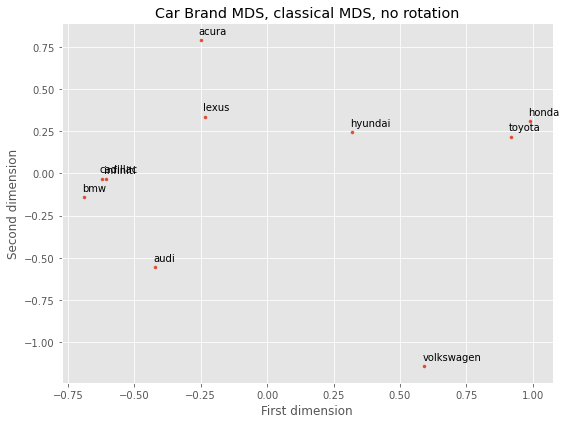

In [28]:
# get MDS points
X = cMDS(df_transformed, 2)
# plot
plot(X, df_transformed.columns.values, algorithm = 'classical MDS, no rotation')

Note: Cadillac and Infiniti are very similar to each other, so their labels overlap each other and are hard to read.

## Task E: Insights from C and D

### Similarity Matrix + Analysis

The associations between any of the ten most popular car brands from the Edmunds entry level luxury car forum can be seen in the lift matrix in Part C. These values are based on the frequency with which two brands are mentioned in the same message. It is worthwhile to note that if mentions of the two brands are separated by more than seven words in a post, that post is not included in the lift calculations. Higher lift values suggest stronger associations. For this analysis, lift values greater than 2 indicate a strong association between two brands, lift values between 1.5 and 2 reveal a moderate association, and lift values ranging from 1 to 1.5 represent a slight association. A lift value of 1 or below suggests that the two brands are independent; this is interpreted to mean that the two brands are not compared by users of this Edmunds forum.

**Strong Association**

Only a few brands have a strong association with one another. The strongest association is between Lexus and Infiniti with a lift value of 4.51. This means that Edmunds users who mention Lexus in their posts are over four and a half times more likely to mention Infiniti in their writing than pure chance predicts (and vice versa). This is not too surprising given the structure of these companies and their market positioning. Lexus serves as a luxury car division of its parent company, Toyota. Infiniti is a luxury car division of another Japanese automaker, Nissan. Their parent companies (Toyota and Nissan) need to establish competitive advantages over each other in their everyday vehicle offerings, and it makes sense for this highly competitive environment between the two brands to translate to the luxury vehicle space. Other strong associations gathered from the matrix include Lexus and Cadillac (lift of 2.958), Acura and Infiniti (2.752), Toyota and Honda (2.291), Honda and Acura (2.180), and Lexus and Toyota (2.134). For the Lexus and Cadillac association, it should be pointed out that Cadillac is one of the premier North American-based luxury brands, meaning that its general business specialization (luxury) is very similar to that of Lexus; because of this, Cadillac and Lexus models typically focus on the car's aesthetics above all else, with the most prominent difference between the two brands being their locale (U.S. and Japan). A traditional rivalry exists between Cadillac’s CT models and Lexus’s IS luxury car models, which could explain the frequent discourse between the two brands among forum users. The Acura and Infiniti association offers a similar qualitative justification to the Lexus and Infiniti. Acura is a luxury car division of Honda in the same way that Infinity is a luxury car division of Nissan. Therefore, as was the case with Lexus and Infiniti, their parent companies both attempt to capture as much market share of the Japanese car market as possible, leading them to look for competitive advantages over one another constantly.


Because of their continual competition, Edmunds users’ pairwise mentions of these brands is sensible. Another unsurprising insight can be derived from the association between Toyota and Honda. In the general car production landscape, these two brands have maintained a classic, long-lasting rivalry due to their perception as the two dominant Japanese car companies. This can be observed through both brands’ entry-level models becoming increasingly common worldwide, as is seen via Toyota’s Corolla and Camry models and Honda’s Accord model. These factors can reasonably explain their consistent mentions among the users’ posts in the Edmunds forum. For both the Honda and Acura and Lexus and Toyota associations, perhaps the most robust reasoning behind a strong association relates to the fact that one brand is merely a luxury subsidiary of the other. After all, Acura is Honda’s luxury division, and Lexus is Toyota’s luxury division. Suppose customers possess significant brand loyalty to the parent companies (Honda and Toyota). In that case, it is plausible to suspect that such loyalty will likely translate to the luxury divisions. In a sense, the luxury subsidiaries are simply extensions of the parent brands. Therefore, users engaging in numerous conversations containing the two brands in the Edmunds forum is not overly shocking to see.

**Moderate Association**

Several brands possess moderate pairwise associates with one another, per the maximum word separation of 7 words. When examining these associations, three particular associations will be keyed in on. These three associations are Toyota and Hyundai (lift of 1.869), Volkswagen and Audi (1.80), and Infiniti and Cadillac (1.75), which have lift values that are some of the highest in the range of potential moderate associations (lift between 1.5 and 2). They also offer perhaps the most intriguing insights regarding the frequency of discourse for the two brands among Edmunds forum users. For the association between Toyota and Hyundai, they are not precisely direct competitors based on geographic region (Hyundai is a South Korean company, whereas Toyota is based in Japan). However, they both are traditionally perceived to maintain a lesser focus on high performance in producing their car models. The primary difference between the two brands in terms of overall perception is that Hyundai is viewed as more high-end and less mainstream when compared with Toyota. Despite this difference, both brands are still competitors in producing affordable yet sleek and nice-looking vehicles. Due to this evident competition, the frequent pairwise conversation surrounding these brands in the Edmunds forum becomes more apparent. However, the plausibility of the connection between the two brands is not immediately evident. For the association between Volkswagen and Audi, both brands are direct competitors based on geographic region, as both companies are based in Germany. That being said, the specializations of both brands are slightly different. Volkswagen prides itself on providing cars that serve the needs of everyday working people without a massive focus on attributes such as high-end, powerful performance (like 0-60 acceleration). By contrast, Audi traditionally emphasizes performance-related attributes while maintaining a sense of luxury in the models the brand offers. The companies are similar in that they mainly produce sports cars with considerable innovation in their development, suggesting that both companies’ user bases will likely overlap. As such, the discourse surrounding both companies in the forum is more reasonable than what might appear on the surface.

Additionally, when honing in on the Infiniti and Cadillac association, there is no direct competition based on company locale (Infiniti operates under a Japanese-based parent company, and Cadillac is a subsidiary of a North American parent company (General Motors)). This association is the least surprising out of the moderate associations mentioned. Both brands possess a very similar brand identity, mainly specializing in producing performance-based luxury sedans. They both place great importance on luxury and car aesthetics, but traditionally speaking, the performance of the cars is held in a slightly higher regard. Because of these commonalities, Edmunds forum users' frequent mentions of the two brands together are reasonably explained and expected.

**No/ Limited Association**

Numerous brands have brand association lifts that are less than 1. In these instances, users are no more likely to mention both brands together than if the brand were utterly independent (mentioned by pure chance). Two examples of such associations are found in the association between Volkswagen and Lexus (lift of 0.353) and between Toyota and Audi (0.335). As it concerns the Volkswagen and Lexus association, the low association is likely due to the differences in how each company positions itself in the car production space. As suggested by its name (which translates to “people’s car”), Volkswagen prides itself on affordability and innovation without dominating emphasis on luxury and overall aesthetics. On the other hand, Lexus positions itself as a maker of high-end luxury cars, with a greater focus on high performance than a company like Volkswagen. It is not a brand that is necessarily at the forefront of innovation, and its vehicles are typically at a higher price point relative to Volkswagen models. Similarly, the low association between Toyota and Audi is likely due to differing brand positions. Toyota is positioned as a company that produces affordable, reliable, and durable vehicles without an overwhelming focus on luxury or high-end automobile performance. Audi, by contrast, emphasizes the combination of both performance and luxury. Traditionally, the brand constantly seeks innovation to strengthen attributes like engine power, acceleration, tire grip, etc., without considering the vehicle’s price point. Therefore, it is no surprise that Edmunds forum users do not go out of their way to mention Toyota and Audi together.


### Dissimilarity Matrix + MDS Map

The MDS map (see Part D) shows how the ten brands compare to each other. In the MDS map, if two points (brands) are closer together, they are deemed less dissimilar (more similar). Clusters of brands are formed along two dimensions, integrating information from the 1/Similarity Matrix (see Part D). As such, five total clusters of brands emerge from the MDS map. Three of the derived clusters contain more than one brand. The first of these clusters is BMW, Cadillac, Infiniti, and Audi; the second cluster is Lexus and Acura, and the third multi-brand cluster is Toyota and Honda. Clusters four and five consist of only one brand, Hyundai and Volkswagen respectively. The following paragraphs highlight the most critical insights and commonalities individual to each cluster, revealing some of the unique characteristics present in each cluster.

**Cluster One:** In the first cluster (BMW, Cadillac, Infiniti, Audi), all four companies are lauded as innovative, luxury manufacturers that produce high-end vehicles. This intent on being innovative can be observed through the companies’ slogans. For instance, the slogan of Nissan, Infiniti’s parent company, is “innovation that excites,” and BMW goes out of its way to stake its claim as the “ultimate driving machine.” High performance is a clear priority for these brands, without any concern for the price point at which their vehicles are sold. Perhaps the most surprising observation in this cluster is that Cadillac and Infiniti are closely adjacent, where one is almost on top of the other in the MDS map. This suggests that these two brands might be more suitable competitors than previously thought. They both place greater importance on the performance of their models over their luxury status. Consumers seem to view Cadillac and Infiniti similarly despite the differences in production origin. 
Another unexpected insight from the first cluster is that BMW is the furthest away from Audi in the cluster, despite Audi being regarded as BMW’s foremost competitor. Instead, it is the closest to Cadillac, an American luxury car company, over the performance-focused Audi brand. At first glance, this seems somewhat surprising. However, both brands, similar to the rest of the cluster, possess strong competencies in making high-performance luxury sedans and are known for such sedans in the minds of consumers, according to data from Edmunds forum posts. Audi is traditionally known for its coupe models, an area where BMW does not aggressively target in its car production. The massive positional difference between BMW and Cadillac is its country of production origin, which is not a vital attribute regarding entry-level luxury cars. Therefore, BMW might want to study Cadillac or Infiniti to develop competitive advantages over the luxury car production space instead of their traditional brand rival, Audi.

**Cluster Two:** The second cluster (Lexus and Acura) encompasses two brands that are strong in both luxury and reliability without too much focus on high-end, performance-inspired innovation. Similar to the first cluster, these brands do not possess immense concern regarding the affordability of their vehicles, at least about the other top 10 brands in the Edmunds forum. Unlike the previous cluster, the insights derived here are not overly unexpected. The rivalry between the two brands’ parent companies, Toyota and Honda, appears to extend to that of their high-end luxury divisions, striving to make cars that balance durability and elegance. Lexus and Acura, while not inexpensive, are thought of as less pricey than BMW and Audi sport models, for example, further differentiating themselves from the first cluster. Based on the MDS map, it seems safe to assume that Lexus is Acura's main competitor of the ten most popularly mentioned brands, and vice versa. 

**Cluster Three:** The third cluster (Toyota, Honda) comprises the parent-mentioned companies of Lexus and Acura, emphasizing reliability and affordability. The two brands in the cluster are not overly innovative regarding traditional car performance. Instead, they focus on developing models that reduce MPG, increase fuel efficiency, and are highly durable, placing these attributes above all else. As previously stated, there has been constant competition between the two brands over multiple decades, with each company continually vying to outperform the other in various automobile market segments. Toyota and Honda are also perceived as more mainstream and popular brands, often many drivers’ first vehicles. Because of these factors, their proximity on the MDS map is no great shock. It justifies the existing notion that Toyota is Honda’s most significant competitor (and vice versa) via Edmunds user posts.

**Chapter Four:** The fourth cluster (Hyundai) is one of the two clusters where a brand appears separated from the others, not aptly fitting into any of the three mentioned clusters. It serves as a middle ground relative to the other clusters on the MDS map, as the brand uniquely has attributes and positions. In general, Hyundai is less affordable and mainstream when compared to the cost-conscious Toyota and Honda brands, though it is noticeably more luxury-oriented than both brands. However, it is not a dominating focus of Hyundai to overhaul their aesthetics to the point where their models are directly comparable to Lexus and Acura. The company also engages in a fair amount of high-end, performance-focused innovation. However, it is not perceived as reliable in the way their fellow Asian manufacturers (Toyota and Honda) are. Although performance is considered when producing Hyundai luxury models, the brand is not as oriented around street performance as the brands in the first cluster (i.e., BMW and Audi). They do not lose sleep over perfecting attributes like high-end engines, acceleration optimization, handling, etc. Due to these stark differences between Hyundai and the other nine popular brands in the Edmunds forum, it is evident that no comparable competitor is plotted in the MDS map for Hyundai.

**Chapter Five:** The fifth and final cluster (Volkswagen) is another example of a brand not overwhelmingly close to the other nine brands on the MDS map. Like Hyundai, Volkswagen is isolated from the three grouped clusters (comprising multiple brands). The brand positions itself as an affordable company ripe in innovation, though not about high street performance. Alternatively, the innovation concerns environmental health factors, like lower fuel consumption, cleaner emissions, and overall eco-friendliness. Volkswagen (“people’s car”) has also maintained its historical focus on serving as the auto manufacturer for the everyday working person, keeping their model price points inexpensive. From a performance standpoint, Volkswagen is comparable to the reliable Toyota and Honda models. Unlike Toyota and Honda, the brand has a demographic perception that differs from theirs. Simply put, Volkswagens are not precisely the first cars that come to mind when young buyers are ready to purchase their first vehicles. The brand has the perception of being dominated by older consumers, leading many younger people to distance themselves from its entry-level luxury models. In addition, Volkswagen dramatically differs from the brands in the first cluster (BMW, Cadillac, Infiniti, Audi). While constant innovation is a significant component of its brand identity, the brand does not possess a proper specialization in producing high-performance luxury sedans. It also does not tend to market its cars as overly luxurious and fashionable, further contributing to its unpopular perception among young people. Furthermore, as with BMW and Audi, Volkswagen is not focused on street performance. Instead, the brand is more intent on affordability, reliability, and durability, like the brands in the third cluster. As observed from the MDS plot and the associated qualitative explanation, Edmunds forum users do not seem to sufficiently compare Volkswagen with any of the other nine plotted brands. Given the forum data, this indicates that among the other nine most popularly mentioned brands, there is not one suitable competitor to Volkswagen.

## Task F: Car Attributes
The most frequently occurring attributes in messages are:
1. price
2. sport
3. engine
4. performance
5. luxury

In [29]:
display(attr_lift_matrix)

,engine,luxury,performance,price,sport
,,,,,
acura,0.620469,0.864467,0.566297,0.544519,0.354569
audi,0.709131,0.648135,0.553159,0.695543,0.844059
bmw,0.626808,0.573437,0.557414,0.725803,1.142204
cadillac,0.081559,1.408054,0.166392,0.623307,0.161007
honda,0.501446,0.665927,0.354122,0.321586,0.647249
hyundai,0.537490,1.443448,0.000000,0.746854,0.618954
infiniti,0.575209,0.496524,0.366719,0.099908,0.283881
lexus,0.177226,0.917899,0.271174,0.738780,0.524797
toyota,0.345125,0.198610,0.704101,0.239779,1.192301


## Task G: Advice from F

The five attributes most frequently mentioned in the discussion of cars in this forum for entry-level luxury cars are: engine, luxury, performance, price and sport. The above table shows the pairwise lift values between each of these attributes or features and the 10 brands most discussed on the Edmunds forum. Many of the brands do not have lift values above 1 for these attributes, meaning they are not co-mentioned frequently enough to yield a predictive relationship. “Luxury” and “sport” have significant lifts with several brands, so those will be discussed in individual sections of this analysis. There will then be a brief commentary on brands that are notably not co-mentioned with the five aforementioned attributes, and what that indicates about their branding strategies. The final piece of our analysis will provide individual brand advice for Acura, Audi, BMW, Cadillac, Honda and Hyundai. 

### Luxury
The prestigious European brands in this dataset, such as Audi and BMW, may believe that their names are always associated with luxury and performance. In actuality, only Cadillac and Hyundai are consistently mentioned alongside luxury. Edmunds publishes an annual list of Top 10 luxury car brands (Frio 2023). Three of these brands show up in the top 10 most mentioned brands on the Edmunds forum: Audi, BMW and Cadillac. Of these, Cadillac is the only brand that is described as luxury on the actual Edmunds forum. How is it possible that Edmunds can consider Audi and BMW to be luxury car brands, but the car enthusiasts and consumers writing about these brands don’t? Edmunds cites the Audi’s “sporty handling”, yet Audi and sport are infrequently mentioned in the same message! 

Consumers no longer see Audi and BMW as synonymous with luxury, or perhaps these brands are now viewed as offering baseline luxury, with expectations rising for higher end features and standards. What was once considered luxury has now become the baseline expectation. These brands need to remind their potential customers that their cars are worth the price tag for more than name-value alone. Recent Audi branding has focused on their engineering advantage and commitment to intelligent design. (Prestige Imports, 2023). This is not appealing to the new generation of car purchasers that are more focused on features and ease of use than 0-60 times (Gonzalez 2022). A BMW 528i had a 0-60 time of 7 seconds in 1999; today’s Honda Civic 1.5T can do 0-60 in 6.8 seconds. The same measures of performance and luxury from 20 years ago are now table stakes. In fact, the modern consumer’s focus on safety and reliability could mean that emphasizing straight line speed and handling through turns may dissuade them from purchasing high-end vehicles marketed as pseudo-race cars.

Hyundai is co-mentioned with luxury more than would be predicted by chance alone. The manufacturer has recently moved into producing larger SUVs and EVs, both of which could evoke a sense of luxury. The price tag of these models are comparable with basic Audis or BMWs, providing the consumer more luxury per dollar when they buy a Hyundai. Hyundai should continue to surprise its customers with features and innovations long associated with brands like BMW. Balancing the branding of reasonable prices and luxury requires them to remain competitive in both the entry-level and high-end markets. This dichotomy is what sets them apart from other brands like Audi or BMW. 

### Sport

BMW and Toyota show up more often in posts alongside “sport” (lifts of 1.14 and 1.19 respectively). Many Toyota ads are filmed in nature, with the cars seen racing through deserts or forests. Their 2022 Super Bowl ad showed Tommy Lee Jones and Leslie Jones racing Tacomas through a scene of the wild west (Lutz 2022). These associations with good handling in all terrain and speed may contribute to their image as a “sporty” car. BMW’s advertising underpinning the tagline of “The Ultimate Driving Machine” has enhanced its perception as a sporty car. However, this has not translated to broader discussions about luxury and performance. 

None of the brands have a predictive association with “engine”, “performance”, or “price” (all lifts are below 1). Discussion of engine performance or quality may be more important when comparing between specific models instead of between brands. Audi, BMW and Cadillac frequently reference engine performance to support their brand image of performance and luxury. Engine is not a unique differentiating point, but it may contribute to measures of performance. If brands were successfully convincing customers to value their cars based on engine performance we would see an increase in association between performance and the brands with this marketing strategy. However, there are also no increases in associations between performance and any of these brands. This could be an indicator that performance is changing from a measure of handling and speed to a measure of reliability. Young consumers, particularly women, are increasingly concerned with safety and car reliability. European luxury cars are considered temperamental and expensive to fix (Honest Accurate Auto 2023); competitors can capitalize on this to push an association with performance that also emphasizes reliability as opposed to the actual driving experience. 

Brands should shy away from directly mentioning their absolute pricing since it provides an easy competitive edge for other brands; only one can truly be the cheapest. They will instead show how much more you get for the price with their car compared to a competitor. This suggests that conversations of luxury brands, such as the forum we scraped, are driven by feature reviews rather than pricing; price is only relevant as a comparative metric for the number of features or positive attributes provided per dollar. 

### Individual Brand Advice:

**Audi:** Audi should lean into its motorsport history to sell its brand as a lifestyle choice. Nods to older designs and old-school glamor can help balance technological innovation with curb appeal. Their name-brand will no longer carry them as a competitor in the luxury car market. 

**BMW:** The Ultimate Driving Machine needs to become the Ultimate Driving Experience. Consumers have come to expect vehicle performance; what they want now are tangible representations of luxury in the form of thoughtful features (e.g. cup warmers, quality screens for on-board computers). BMW cannot expect to compete in a world of flashy social media videos by hiding their value under the hood. 

**Cadillac:** Cadillac is performing well in the luxury category and should continue distinguishing itself as American-made luxury. Their customers are usually older, meaning that Cadillac’s main concern should be consumers who are aging into Cadillac’s target demographic (starting at the early 50s) (AskWonder, 2023). 

**Honda:** Honda can take over the performance market by highlighting the associations between reliability and performance, especially in comparison to the traditional luxury brands. After all, what good is a fast car if it breaks down all the time? An idea for an ad campaign could feature a hare and turtle race, ending in a Honda driving past an unnamed luxury European car in the mechanic’s shop. This emphasizes the message that consistency and reliability are far more valuable than fleeting speed. 

**Hyundai:** Hyundai’s association with luxury is likely a function of its comparison with traditional luxury brands. It should lean into this by focusing on surprising levels of luxury. This could be done either by highlighting new features and then revealing the low price, or focusing on “the feeling of luxury when you drive: priceless. Our price: low.” 


### Key Takeaways + Ideas:

1. All brands are failing to associate themselves with performance, price and engine. 
2. Luxury is now a comparative game: how much luxury can a consumer get for the same price?
3. The sport attribute may be cannibalizing performance and dissuading safety-conscious consumers from purchasing "high performance" cars. 


#### Citations
1. https://www.edmunds.com/car-buying/luxury-car-brands.html
Frio, Dan. “Top Luxury Car Brands of 2023.” Edmunds, 13 Oct. 2023, www.edmunds.com/car-buying/luxury-car-brands.html. 

2. https://www.prestigeimports.net/audi-advertising/
“Audi Advertising.” Prestige Imports, Prestige Imports, 2023, www.prestigeimports.net/audi-advertising/.

3. https://www.fastcompany.com/91174669/gen-zs-top-car-must-haves-comfort-and-carplay
Gonzalez, Lisa. "Gen Z's Top Car Must-Haves: Comfort and CarPlay." Fast Company, Fast Company & Co., 11 May 2022, www.fastcompany.com/91174669/gen-zs-top-car-must-haves-comfort-and-carplay.

4. https://adage.com/creativity/work/toyota-super-bowl-ad-has-famous-joneses-and-jonas/2400406
Lutz, Ashley. "Toyota Super Bowl Ad Has the Famous Joneses and the Jonas." Ad Age, Crain Communications, 7 Feb. 2022, www.adage.com/creativity/work/toyota-super-bowl-ad-has-famous-joneses-and-jonas/2400406.

5. https://honestaccurateauto.com/uncategorized/european-car-maintenance-and-the-cost-of-ownership/
“European Car Maintenance and the Cost of Ownership.” Honest Accurate Auto, Honest Accurate Auto, 2023, www.honestaccurateauto.com/uncategorized/european-car-maintenance-and-the-cost-of-ownership/.

6. ​​https://start.askwonder.com/insights/cadillac-xts-mid-sized-suv-having-hard-time-moving-i-d-insights-buying-mid-sized-7xm0oocgg#:~:text=Demographic%20Profile%20of%20the%20Mid%2DSize%20Luxury%20SUV%20Consumer&text=Mid%2Dsize%20premium%20Cadillac%20SUV,average%20is%2056%2D57%20years.
“Cadillac XTS: Mid-Sized SUV Having a Hard Time Moving.” AskWonder, Wonder, 2023, start.askwonder.com/insights/cadillac-xts-mid-sized-suv-having-hard-time-moving-i-d-insights-buying-mid-sized-7xm0oocgg.


## Task H: Aspirational Brands
Our aspirational terms are:
1. dream of
2. want to own
3. want to buy
4. goal of mine
5. dream car
6. saving for
7. save up
8. future purchase
9. hopefully own

In [30]:
# Initialize global variables and data structures
df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])  # To store lift values
word_frequency = {}  # Dictionary to store word frequency in posts
word_pair_frequency = defaultdict(dict)  # Dictionary to store word pair co-occurrence frequency
results_dict = {}  # Dictionary to store results with lift values for word pairs
file_length = 0  # Number of rows in the input file
itr = 0  # Row iterator for the lift DataFrame

# File paths
input_file = 'data/replacement_Edmunds.csv'  # Input data file
pair_keys_file = 'edmunds_pair_keys.txt'  # File containing the words to calculate lift
output_lift_values = 'data/Lift_Values2.csv'  # Output file for lift values
output_lift_matrix = 'data/Lift_Matrix2.csv'  # Output file for lift matrix

# Load NLTK stopwords
stop_words = set(stopwords.words('english'))

# Step 3: Calculate word frequencies and word pair co-occurrences (distance ≥ 5 words)
def calculate_frequencies_2(posts):
    """
    Calculates the frequency of individual words and word pairs within the posts.
    Updates the global word_frequency and word_pair_frequency dictionaries.
    Only considers word pairs that are 5 or more words apart.
    """
    global word_frequency, word_pair_frequency

    for post in posts:
        word_positions = {}  # Dictionary to track positions of each word

        # Track word positions
        for idx, word in enumerate(post):
            if word not in word_positions:
                word_positions[word] = []
            word_positions[word].append(idx)

        # Count word frequencies
        unique_words = set(post)  # Track unique words in the post to avoid double counting
        for word in unique_words:
            word_frequency[word] = word_frequency.get(word, 0) + 1

        # Track word pairs that have already been marked as co-occurring in this post
        seen_pairs = set()
        # Count word pair co-occurrences with distance check
        for word1 in word_positions:
            for word2 in word_positions:
                if word1 != word2 and (word1, word2) not in seen_pairs:
                    # Check if the words are 5 or fewer positions apart
                    found_pair = False
                    for pos1 in word_positions[word1]:
                        for pos2 in word_positions[word2]:
                            if abs(pos1 - pos2) <= 15:
                                word_pair_frequency[word1][word2] = word_pair_frequency.get(word1, {}).get(word2, 0) + 1
                                seen_pairs.add((word1, word2))  # Mark this pair as seen
                                found_pair = True
                                break  # No need to check more positions; move to the next pair
                        if found_pair:
                            break  # Stop after finding one valid pair in this post
                            

# Main function to run all steps
def main():
    # Step 1: Load word pairs
    word_pairs = load_word_pairs(pair_keys_file)

    # Step 2: Process the input file to extract posts
    posts = process_input_file(input_file)

    # Step 3: Calculate frequencies
    calculate_frequencies_2(posts)

    # Step 4: Calculate lift values
    df_lift = calculate_lift(word_pairs)

    # Step 5: Save results
    save_results(df_lift)

# Run the script
if __name__ == "__main__":
    main()


In [31]:
# create lift matrices for brands, attributes, and aspiration
df_lift = pd.read_csv('data/Lift_Values2.csv')

# aspiration lift matrix
mask = (df_lift['word1'].str.contains('bmw|audi|acura|honda|volkswagen|infiniti|cadillac|toyota|lexus|hyundai') &
        df_lift['word2'].str.contains('aspiration'))
asp_lift = df_lift[mask]
asp_lift_matrix = pd.pivot_table(asp_lift, values='lift_value', index='word1', columns='word2', fill_value=0)
asp_lift_matrix.index.name = ''
asp_lift_matrix.columns.name = ''
display(asp_lift_matrix)

,aspiration
,
acura,0.000000
audi,1.192748
bmw,1.838235
cadillac,1.554726
honda,1.470588
hyundai,0.000000
infiniti,0.000000
lexus,0.000000
toyota,0.000000


Our analysis considered the above terms to reflect consumer aspiration without significant information bleed-over to other meanings. These terms were
replaced by “aspiration” in the list of posts in order to measure the co-occurrences of brands and aspiration. By replacing these terms, BMW was identified as the most aspirational brand, closely followed by Cadillac and Honda. BMW has managed to capture consumers' imaginations without conquering the luxury association game. Dreams seem to linger longer than feature associations.

Given this positioning, an aspirational brand such as BMW may benefit more from targeted sales events than other brands. They could have exclusive “insider events” that allow BMW enthusiasts and hopeful owners to engage with the brand more directly. These events could also showcase models at more accessible prices through limited time promotions, where the volume of sales offsets the discounts. The goal would be to create a focused environment where consumers that view BMW as a status symbol could turn their aspirations into reality.

In addition to this, leveraging digital marketing strategies would amplify these efforts. Targeted ads on social media, tailored based on users’ browsing habits, and personalized campaigns could make these sale events more enticing and widespread. By aligning BMW’s luxury image with promotional offers in the right channels, the brand could further capitalize on its aspirational appeal, converting more potential consumers into actual owners. 